In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def numpy_metrics(y_pred, y_true, n_classes=11, void_labels=[11]):
    """
    Similar to theano_metrics to metrics but instead y_pred and y_true are now numpy arrays
    from: https://github.com/SimJeg/FC-DenseNet/blob/master/metrics.py
    void label is 11 by default
    """

    # Put y_pred and y_true under the same shape
    y_pred = np.argmax(y_pred, axis=1)

    # We use not_void in case the prediction falls in the void class of the groundtruth
    not_void = ~np.any([y_true == label for label in void_labels], axis=0)

    I = np.zeros(n_classes)
    U = np.zeros(n_classes)

    for i in range(n_classes):
        y_true_i = y_true == i
        y_pred_i = y_pred == i

        I[i] = np.sum(y_true_i & y_pred_i)
        U[i] = np.sum((y_true_i | y_pred_i) & not_void)

    accuracy = np.sum(I) / np.sum(not_void)
    return I, U, accuracy

In [3]:
def eval_uncertaintry_metrics(y_pred, y_true, uncertainty_map, patch_size=7, acc_threshold=0.5, cert_threshold=0.4):
    #TODO verify y_pred, y_true size and representation
    # Assume y_pred (batch_size, num_classes, h, w) where h = w = 224
    # y_true (batch_size, h, w)

    batch_size, num_classes, w, h = y_pred.shape

    # Put y_pred and y_true under the same shape
    y_pred = np.argmax(y_pred, axis=1)
    
    acc_flag = y_pred == y_true
    acc_grid = acc_flag.reshape(batch_size, w//patch_size, patch_size, h//patch_size, patch_size)
    acc_grid = np.swapaxes(acc_grid, 2, 3).reshape(batch_size, -1, patch_size, patch_size)
    _, num_patch, _, _ = acc_grid.shape
    acc_rate = np.sum(np.sum(acc_grid, axis=3), axis=2)/(patch_size * patch_size) # (batch_size, w//patch_size * h//patch_size)

    cert_grid = uncertainty_map.reshape(batch_size, w//patch_size, patch_size, h//patch_size, patch_size)
    cert_grid = np.swapaxes(cert_grid, 2, 3).reshape(batch_size, -1, patch_size, patch_size)
    cert_rate = cert_grid.mean(axis=(2,3)) # (batch_size, w//patch_size * h//patch_size)

    acc = acc_rate > acc_threshold
    cert = cert_rate > cert_threshold

    n_ac = np.sum(np.logical_and(acc, cert), axis=1)
    n_au = np.sum(np.logical_and(acc, np.logical_not(cert)), axis=1)
    n_ic = np.sum(np.logical_and(np.logical_not(acc), cert), axis=1)
    n_iu = np.sum(np.logical_and(np.logical_not(acc), np.logical_not(cert)), axis=1)

    p_a_c = n_ac/(n_ac + n_ic) # p(accurate|certain)
    p_u_i = n_iu/(n_ic + n_iu) # p(uncertain|inaccurate)
    pa_v_pu = (n_ac + n_iu)/num_patch # Patch Accuracy vs Patch Uncertainty

    return p_a_c, p_u_i, pa_v_pu

In [4]:
def softmax(x, axis=1):
    return np.exp(x) / np.sum(np.exp(x),axis=axis, keepdims=True)

In [5]:
def ece(outputs, labels, name="", bins=np.arange(0.1, 1.05, 0.05), print_name=False, background_label = 11):

    if outputs is None:
        ece = None
    else:
        confidences = np.max(outputs, 1)
        predictions = np.argmax(outputs,1)
        bin_lowers = bins[:-1]
        bin_uppers = bins[1:]
        
        accuracies = predictions == labels 

        #ece = Variable(torch.zeros(1)).type_as(confidences)
        ece = 0.0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = (confidences > bin_lower) * (confidences < bin_upper)
            prop_in_bin = in_bin.mean()
            if prop_in_bin > 0:
                accuracy_in_bin = accuracies[in_bin].mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin-accuracy_in_bin) * prop_in_bin
    if print_name:
        print(name, end=": ")
    if ece is not None:
        print("%.3f"%ece)
    else:
        print("-")
    return ece



In [6]:
def compute_mIOU_acc(loc, output_probs = True, background_class = 11):
    npz_arr = np.load(loc)
    
    if output_probs:
        pred_probs = npz_arr['predictions']
    else:
        pred_probs = softmax(npz_arr['preds'],1)
    targets = npz_arr['targets']
    
    I, U, acc = numpy_metrics(pred_probs, targets)
    mIOU = np.mean(I / U)
    
    filtered_targets = targets.reshape(-1)
    background_labels = filtered_targets == background_class
    filtered_targets = filtered_targets[~background_labels]
    
    filtered_pred_probs = pred_probs.reshape(-1, pred_probs.shape[1])
    print(filtered_pred_probs.shape, filtered_pred_probs.sum(1).mean())
    filtered_pred_probs = filtered_pred_probs[~background_labels, :]
    
    ece_val = ece(filtered_pred_probs, filtered_targets, print_name=False)
    print(acc, mIOU, ece_val, loc)
    return acc, mIOU, ece_val

In [7]:
# compute_mIOU_acc('../../swag_diag2.npz')

In [8]:
npz_arr = np.load('../../swag_diag2.npz')

In [9]:
list(npz_arr.keys())

['predictions',
 'targets',
 'scales',
 'predictive_entropy',
 'mutual_information']

In [10]:
targets = npz_arr['targets']
targets.shape

(233, 360, 480)

In [11]:
pred = npz_arr['predictions']
pred.shape

(233, 11, 360, 480)

In [12]:
pred_uncertainty = npz_arr['predictive_entropy']
pred_uncertainty.shape

(233, 360, 480)

In [13]:
mut_uncertainty = npz_arr['mutual_information']
mut_uncertainty.shape

(233, 360, 480)

In [26]:
p_a_c, p_u_i, pa_v_pu = eval_uncertaintry_metrics(pred, targets, pred_uncertainty, patch_size=6)

In [41]:
p_a_c.shape, p_u_i.shape, pa_v_pu.shape

((233,), (233,), (233,))

In [14]:
import utils.imgs as img_utils

In [15]:
pred_labels = np.argmax(pred, axis=1)

In [19]:
entropy_max, entropy_min = pred_uncertainty.max(), pred_uncertainty.min()
pred_cert_viz = pred_uncertainty/entropy_max*255

info_max, info_min = mut_uncertainty.max(), mut_uncertainty.min()
info_cert_viz = mut_uncertainty/info_max*255

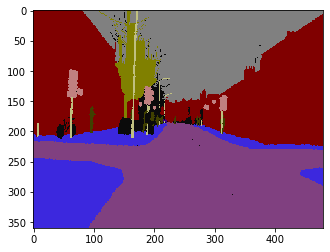

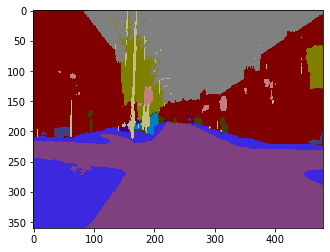

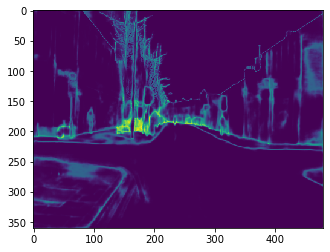

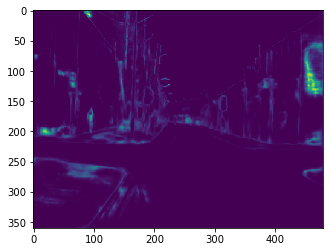

In [21]:
for i in range(1):
#     img_utils.view_image(inputs[i])
    img_utils.view_annotated(targets[i])
    img_utils.view_annotated(pred_labels[i]) 
    plt.imshow(pred_cert_viz[i])
    plt.show()
    plt.imshow(info_cert_viz[i])
    plt.show()